In [48]:
import os
import shutil
import random
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision import  transforms
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
from torchsummary import summary
import cv2

In [49]:
model=YOLO(r'runs\detect\train\weights\best.pt')

In [50]:
print(model.model)


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

In [ ]:
def detection_inference(img_path, max_h=600):
    """
    Detect, draw, resize, show INLINE, return tensors.
    """
    r = model(img_path,conf=0.25, iou=0.45)[0]
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(img_path)
    
    h_orig, w_orig = img.shape[:2]
    scale = max_h / h_orig
    new_size = (int(w_orig * scale), int(h_orig * scale))
    img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)

    if len(r.boxes):
        boxes  = r.boxes.xyxy.cpu().numpy()
        clss   = r.boxes.cls.cpu().numpy().astype(int)
        confs  = r.boxes.conf.cpu().numpy()
        
        # scale boxes to the resized image
        boxes = boxes * scale
        class_label=clss[0]

        if class_label == 1:
            colour = (0, 255, 0)                   # GREEN
        else:                                      # Damaged_label (or anything else)
            colour = (0, 0, 255)                   # RED
        
        for box, cls_idx, conf in zip(boxes, clss, confs):
            x1, y1, x2, y2 = box.astype(int)
            label = f"{model.names[cls_idx]} {conf:.2f}"
            cv2.rectangle(img, (x1, y1), (x2, y2),colour, 2)
            w_txt, h_txt = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX,
                                           0.6, 1)[0]
            cv2.rectangle(img, (x1, y1 - h_txt - 4), (x1 + w_txt, y1),
                          colour, -1)
            cv2.putText(img, label, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (0, 0, 0), 1, cv2.LINE_AA)
    else:
        boxes = np.empty((0, 4))
        clss  = np.empty(0)
        confs = np.empty(0)
        cv2.putText(img, "nothing detected", (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # RGB for matplotlib, display inline
    plt.figure(figsize=(new_size[0]/100, new_size[1]/100))  # nice size
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return boxes/scale, clss, confs   # return boxes in ORIGINAL coords


image 1/1 C:\Users\MSI\Documents\GitHub\ClothTagNet\Label_data\images\2bb14a29-PXL_20251008_152245426.jpg: 224x128 1 Damaged_label, 15.4ms
Speed: 0.9ms preprocess, 15.4ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 128)


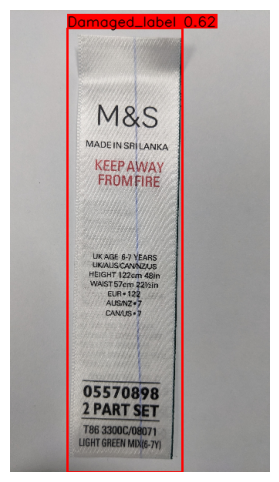

(array([[     498.58,      161.26,      1504.6,        4032]], dtype=float32),
 array([0]),
 array([    0.61721], dtype=float32))

In [76]:
detection_inference(r'C:\Users\MSI\Documents\GitHub\ClothTagNet\Label_data\images\2bb14a29-PXL_20251008_152245426.jpg')


image 1/1 C:\Users\MSI\Documents\GitHub\ClothTagNet\Label_data\images\1b6b75db-PXL_20251008_155350118.jpg: 224x128 1 Good_label, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 128)


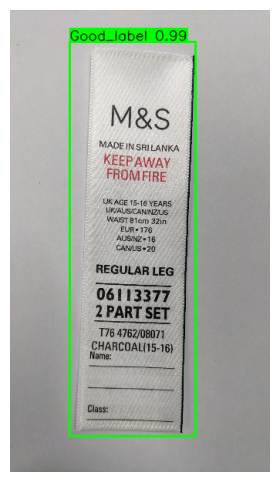

(array([[     521.85,      276.96,      1619.2,      3721.1]], dtype=float32),
 array([1]),
 array([    0.99313], dtype=float32))

In [77]:
detection_inference(r'C:\Users\MSI\Documents\GitHub\ClothTagNet\Label_data\images\1b6b75db-PXL_20251008_155350118.jpg')

This who how the prediction is done

In [54]:
print(model.names)

{0: 'Damaged_label', 1: 'Good_label'}
